# SBA Probability of Default

In [156]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import FunctionTransformer, KBinsDiscretizer, OneHotEncoder
from sklearn.compose import ColumnTransformer

In [74]:
# creates a custom data parser before load data (uses SAS timestamp)
custom_date_parser = lambda x: pd.to_datetime(pd.to_numeric(x), origin='1960-01-01', unit='D')

# load the data into a dataframe
df = pd.read_csv('./data/SBAcase.11.13.17.csv', 
                 parse_dates=['ApprovalDate', 'DisbursementDate', 'ChgOffDate'], 
                 date_parser=custom_date_parser)

naics = pd.read_excel('./data/NAICS.xlsx')

# drop 'extra' variables (based on metadata) and 'Selected' (variable that suggest test train split)
df = df.drop(['Selected', 'daysterm', 'xx'], axis=1)

# drop 'ApprovalFY' because yet it could have a correlation with default (mostly because of financial crisis 2008)
# It doesn't make sense to keep because things change over the years and could not keep correlating that way
# It's better to use a flag like 'Recession' to keep track of financial crisis
df = df.drop(['ApprovalFY'], axis=1)

### Description of Variables

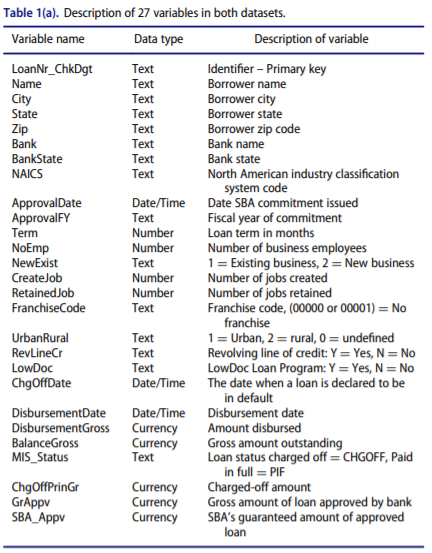 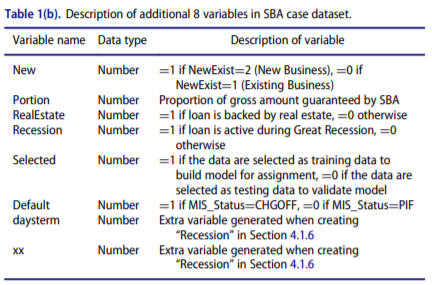

In [75]:
# adjusting 'NewExist' var and drop 'New' (duplicated info)
NewExist = {1: "Existing Business", 2: "New Business", 0: np.nan}

df.replace({"NewExist": NewExist}, inplace=True)
df.drop(['New'], axis=1, inplace=True)

In [76]:
# bring sector using NAICS and then drop the last
df['2D_NAICS'] = df['NAICS'].astype(str).str[:2].astype(int)

df = pd.merge(df, naics, on='2D_NAICS', how='left')
df.drop(['NAICS', '2D_NAICS', 'FullDescription'], axis=1, inplace=True)

In [77]:
# create a column 'Franchise' and drop FranchiseCode
df['Franchise'] = df['FranchiseCode'].apply(lambda x: 'No franchise' if x in [0, 1] else 'Franchise')
df.drop(['FranchiseCode'], axis=1, inplace=True)

In [78]:
# adjusting 'UrbanRural' var
UrbanRural = {1: "Urban", 2: "Rural", 0: np.nan}

df.replace({"UrbanRural": UrbanRural}, inplace=True)

In [79]:
# dropping 'MIS_Status': duplicated info with 'default'

# dropping 'ChgOffPrinGr' and 'ChgOffDate': label var will be 'default''
# I cann't use future information to predict default (when this var is empty it means no default)
df.drop(['MIS_Status', 'ChgOffPrinGr', 'ChgOffDate'], axis=1, inplace=True)

In [80]:
# declaring categorical columns
cat_columns = ['Name', 'City', 'State', 'Zip', 'Bank', 'BankState', 'NewExist', 'UrbanRural', 'RevLineCr', 'LowDoc', 
               'RealEstate', 'Recession', 'Sector', 'Franchise']

df[cat_columns] = df[cat_columns].astype('category')

## 01. Exploratory Data Analysis

In [81]:
# check the shape
df.shape

(2102, 27)

In [82]:
# check for missing values for non categorical columns (missing value for category can be treated as one category itself)
df.select_dtypes(exclude='category').isnull().mean().sort_values(ascending=False)

DisbursementDate     0.001427
LoanNr_ChkDgt        0.000000
ApprovalDate         0.000000
Term                 0.000000
NoEmp                0.000000
CreateJob            0.000000
RetainedJob          0.000000
DisbursementGross    0.000000
BalanceGross         0.000000
GrAppv               0.000000
SBA_Appv             0.000000
Portion              0.000000
Default              0.000000
dtype: float64

In [83]:
# rows with missing values
pd.options.display.max_columns = None
df[df.select_dtypes(exclude='category').isnull().any(axis=1)]

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,ApprovalDate,Term,NoEmp,NewExist,CreateJob,RetainedJob,UrbanRural,RevLineCr,LowDoc,DisbursementDate,DisbursementGross,BalanceGross,GrAppv,SBA_Appv,RealEstate,Portion,Recession,Default,Sector,Franchise
1255,4910065006,Elite Cooling,HUNTINGTON BEACH,CA,92647,JPMORGAN CHASE BANK NATL ASSOC,IL,2011-10-11,84,1,Existing Business,0,0,Urban,Y,N,NaT,14915,0,10000,5000,0,0.5,0,0,Real estate,No franchise
1691,7253454001,UNITY ESCROW INC,ARTESIA,CA,90701,BBCN BANK,CA,2004-03-10,12,13,Existing Business,2,15,Urban,Y,N,NaT,100000,0,100000,50000,0,0.5,0,0,Real estate,No franchise
2101,9958873001,EFM ASSOCIATES,LOS ANGELES,CA,90068,WELLS FARGO BANK NATL ASSOC,SD,1997-02-12,60,4,Existing Business,0,0,NaN,T,N,NaT,35000,0,35000,17500,0,0.5,0,0,Real estate,No franchise


As we have only 3 rows with NaN values, I decided to drop those rows.

In [84]:
# select only numerical columns
cols_to_look = list(df.select_dtypes(exclude='category').columns)

# dropping rows with missing
df = df.dropna(subset=cols_to_look)

In [85]:
# check for constant variables
df.nunique().sort_values()

State                   1
BalanceGross            1
Sector                  1
UrbanRural              2
Default                 2
Recession               2
RealEstate              2
NewExist                2
Franchise               2
RevLineCr               4
LowDoc                  5
BankState              21
Portion                31
CreateJob              43
RetainedJob            62
NoEmp                  83
Bank                  154
Term                  170
DisbursementDate      321
City                  518
GrAppv                659
SBA_Appv              755
Zip                   813
DisbursementGross    1181
ApprovalDate         1365
Name                 2002
LoanNr_ChkDgt        2099
dtype: int64

In [86]:
# drop the columns with unique values
df = df.drop(['State', 'BalanceGross', 'Sector'], axis=1)

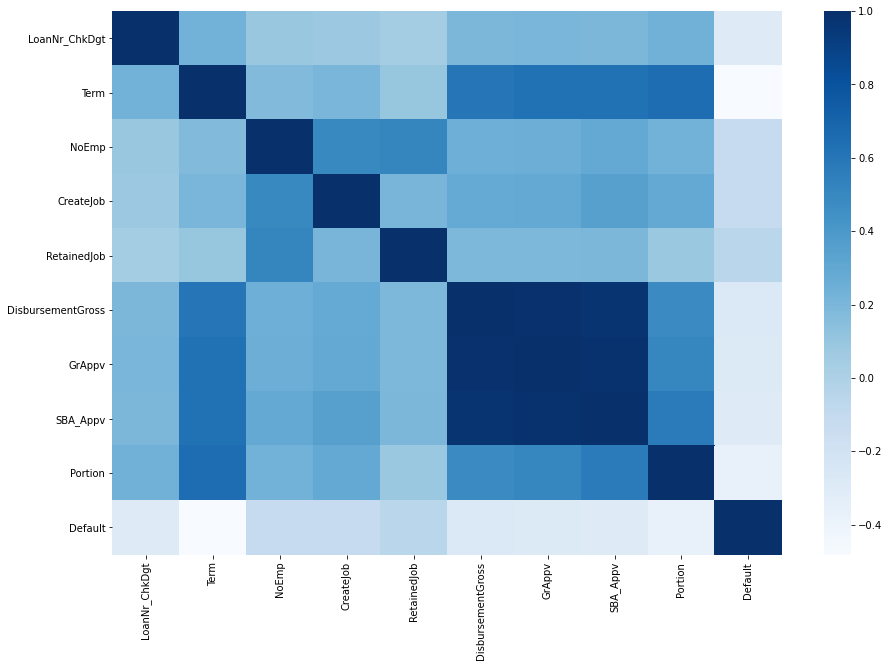

In [87]:
# check correlations
plt.figure(figsize=(15,10))
sns.heatmap(df.corr(), cmap='Blues');

In [88]:
# check some stats
df.describe()

,LoanNr_ChkDgt,Term,NoEmp,CreateJob,RetainedJob,DisbursementGross,GrAppv,SBA_Appv,Portion,Default
count,2.099000e+03,2099.000000,2099.000000,2099.000000,2099.000000,2.099000e+03,2.099000e+03,2.099000e+03,2099.000000,2099.000000
mean,4.465021e+09,127.087661,10.156741,2.552644,5.805145,2.430127e+05,2.333281e+05,1.894117e+05,0.671299,0.326822
std,2.528287e+09,93.816261,34.426110,8.015504,18.989653,3.384465e+05,3.438026e+05,2.990744e+05,0.186540,0.469163
min,1.004285e+09,0.000000,0.000000,0.000000,0.000000,4.835000e+03,4.500000e+03,2.250000e+03,0.296770,0.000000
25%,2.389730e+09,60.000000,2.000000,0.000000,1.000000,4.004350e+04,3.000000e+04,1.500000e+04,0.500000,0.000000
50%,3.617443e+09,84.000000,3.000000,0.000000,2.000000,1.000000e+05,6.200000e+04,4.176000e+04,0.506439,0.000000
75%,6.541004e+09,240.000000,8.000000,2.000000,5.000000,3.000000e+05,3.000000e+05,2.400000e+05,0.850000,1.000000
max,9.925643e+09,306.000000,650.000000,130.000000,535.000000,2.315000e+06,2.350000e+06,2.115000e+06,1.000000,1.000000


In [89]:
def z_outliers(series, z=3):
    '''
    Function that returns a list with True for values considered outlier.
    
    INPUT:
    - series: Pandas Series with variable to check outliers
    - z: number os std devs from the mean to be considered an outlier
    
    OUTPUT:
    - Binary list with True for outliers
    '''
    std = series.std()
    mean = series.mean()
    
    return (series < mean - z*std) | (series > mean + z*std)

In [90]:
# counting outliers per numeric feature
outliers_count = {}

for column in df.select_dtypes('number').columns:
    outliers = z_outliers(df[column])
    outliers_count[column] = df[outliers][column].count()

# calculate percentual of outliers and sort
pd.Series(outliers_count).sort_values(ascending=False)/df.shape[0]

DisbursementGross    0.028109
GrAppv               0.027632
SBA_Appv             0.022392
CreateJob            0.014769
RetainedJob          0.011434
NoEmp                0.010005
LoanNr_ChkDgt        0.000000
Term                 0.000000
Portion              0.000000
Default              0.000000
dtype: float64

In [91]:
# pick only the features with outliers to print distribution
cols_plot = list(pd.Series(outliers_count).sort_values(ascending=False)[:7].index)

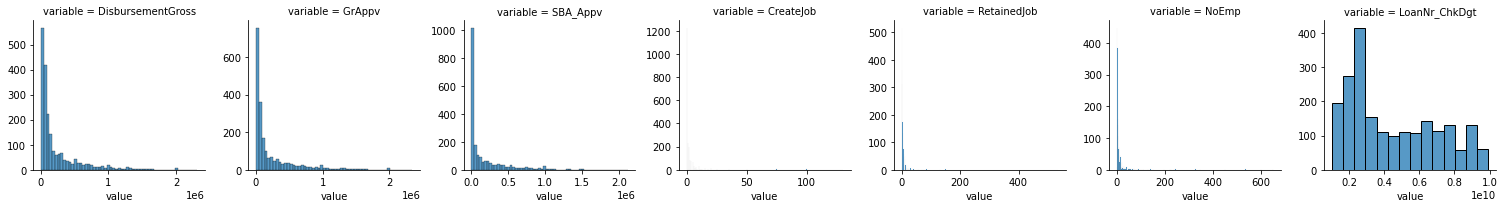

In [92]:
# print the distributions of features with outliers
g = sns.FacetGrid(df[cols_plot].melt(), col='variable', sharex=False, sharey=False);
g.map(sns.histplot, 'value');

In [93]:
df.head()

,LoanNr_ChkDgt,Name,City,Zip,Bank,BankState,ApprovalDate,Term,NoEmp,NewExist,CreateJob,RetainedJob,UrbanRural,RevLineCr,LowDoc,DisbursementDate,DisbursementGross,GrAppv,SBA_Appv,RealEstate,Portion,Recession,Default,Franchise
0,1004285007,SIMPLEX OFFICE SOLUTIONS,ANAHEIM,92801,CALIFORNIA BANK & TRUST,CA,2001-04-09,36,1,Existing Business,0,0,NaN,Y,N,2001-04-30,32812,30000,15000,0,0.5,0,0,No franchise
1,1004535010,DREAM HOME REALTY,TORRANCE,90505,CALIFORNIA BANK & TRUST,CA,2001-06-04,56,1,Existing Business,0,0,NaN,Y,N,2003-09-30,30000,30000,15000,0,0.5,1,0,No franchise
2,1005005006,"Winset, Inc. dba Bankers Hill",SAN DIEGO,92103,CALIFORNIA BANK & TRUST,CA,2001-08-01,36,10,Existing Business,0,0,NaN,Y,N,2001-08-31,30000,30000,15000,0,0.5,0,0,No franchise
3,1005535001,Shiva Management,SAN DIEGO,92108,CALIFORNIA BANK & TRUST,CA,2003-01-14,36,6,Existing Business,0,0,NaN,Y,N,2003-01-31,50000,50000,25000,0,0.5,0,0,No franchise
4,1005996006,"GOLD CROWN HOME LOANS, INC",LOS ANGELES,91345,SBA - EDF ENFORCEMENT ACTION,CO,2006-02-08,240,65,Existing Business,3,65,Urban,0,N,2006-04-12,343000,343000,343000,1,1.0,0,0,No franchise


In [94]:
cols_lt = ['DisbursementGross', 'GrAppv', 'SBA_Appv']
cols_lt_p1 = ['CreateJob', 'RetainedJob', 'NoEmp']
cols_other = [col for col in df.columns if col not in cols_lt + cols_lt_p1]

In [95]:
df = df[cols_lt + cols_lt_p1 + cols_other]

In [96]:
lt = FunctionTransformer(np.log10)
lt_p1 = FunctionTransformer(lambda x: np.log10(x+1))

In [97]:
ct = ColumnTransformer([
    ('log10', lt, cols_lt),
    ('log10+1', lt_p1, cols_lt_p1)
], remainder='passthrough')

dft = ct.fit_transform(df)

dft = pd.DataFrame(dft, columns=df.columns)
dft = dft.infer_objects()

dft

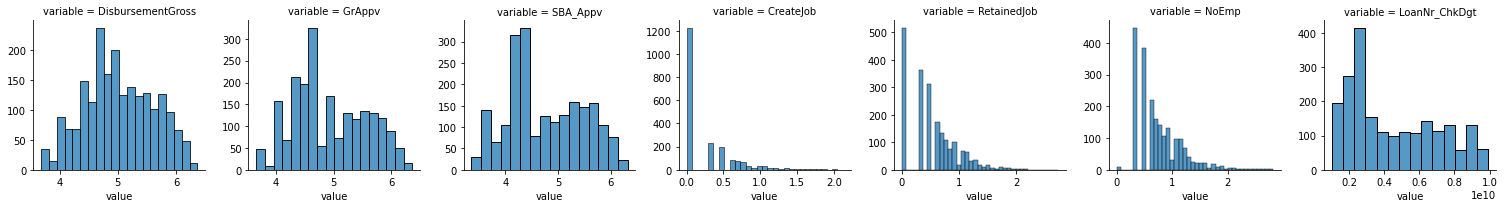

In [101]:
# print the distributions of features with outliers
g = sns.FacetGrid(dft[cols_plot].melt(), col='variable', sharex=False, sharey=False);
g.map(sns.histplot, 'value');

In [102]:
# counting outliers per numeric feature
outliers_count = {}

for column in cols_plot:
    outliers = z_outliers(dft[column])
    outliers_count[column] = dft[outliers][column].count()

# calculate percentual of outliers and sort
pd.Series(outliers_count).sort_values(ascending=False)/dft.shape[0]

CreateJob            0.014293
NoEmp                0.012863
RetainedJob          0.010005
DisbursementGross    0.000000
GrAppv               0.000000
SBA_Appv             0.000000
LoanNr_ChkDgt        0.000000
dtype: float64

In [142]:
# even if log transformation help to reduce outliers and standardize some variables we still find outliers
# I will discretize those vars

In [174]:
discretizer = KBinsDiscretizer(encode='ordinal')
pt = PowerTransformer('box-cox', standardize=False)

ct = ColumnTransformer([
    ('log10', pt, cols_lt),
    ('binarizer', discretizer, cols_lt_p1)
], remainder='passthrough')

dft = ct.fit_transform(df)

dft = pd.DataFrame(dft, columns=df.columns)
dft = dft.infer_objects()

dft

C:\Users\Italo\anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:230: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\Users\Italo\anaconda3\lib\site-packages\sklearn\preprocessing\_discretization.py:230: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  warnings.warn(


,DisbursementGross,GrAppv,SBA_Appv,CreateJob,RetainedJob,NoEmp,LoanNr_ChkDgt,BankState,ApprovalDate,Term,NewExist,UrbanRural,RevLineCr,LowDoc,DisbursementDate,RealEstate,Portion,Recession,Default,Franchise
0,9.952129,7.564201,6.681984,0.0,0.0,1.0,1004285007,CA,2001-04-09,36,Existing Business,NaN,Y,N,2001-04-30,0,0.50,0,0,No franchise
1,9.870082,7.564201,6.681984,0.0,0.0,1.0,1004535010,CA,2001-06-04,56,Existing Business,NaN,Y,N,2003-09-30,0,0.50,1,0,No franchise
2,9.870082,7.564201,6.681984,0.0,0.0,4.0,1005005006,CA,2001-08-01,36,Existing Business,NaN,Y,N,2001-08-31,0,0.50,0,0,No franchise
3,10.337026,7.825347,6.911788,0.0,0.0,3.0,1005535001,CA,2003-01-14,36,Existing Business,NaN,Y,N,2003-01-31,0,0.50,0,0,No franchise
4,12.079186,8.737036,7.951658,2.0,3.0,4.0,1005996006,CO,2006-02-08,240,Existing Business,Urban,0,N,2006-04-12,1,1.00,0,0,No franchise
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2094,13.060381,9.209324,8.326384,2.0,3.0,4.0,9893714004,CO,2006-02-06,240,Existing Business,Urban,0,N,2006-04-12,1,1.00,0,0,No franchise
2095,11.334418,8.359082,7.374978,0.0,2.0,3.0,9893874006,CA,2006-02-06,60,New Business,Urban,0,N,2006-03-31,0,0.50,0,0,No franchise
2096,10.958281,8.161580,7.396896,0.0,0.0,2.0,9901143004,UT,1997-01-16,300,Existing Business,NaN,0,N,1997-01-31,1,0.80,0,0,No franchise
2097,10.337026,7.825347,7.114999,0.0,0.0,2.0,9903293007,CA,1997-01-17,84,Existing Business,NaN,0,N,1997-03-31,0,0.80,0,0,No franchise


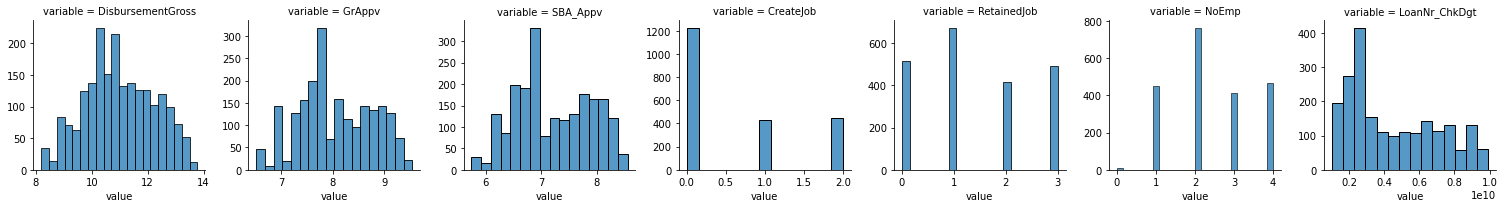

In [175]:
# print the distributions of features with outliers
g = sns.FacetGrid(dft[cols_plot].melt(), col='variable', sharex=False, sharey=False);
g.map(sns.histplot, 'value');

In [178]:
ct.feature_names_in_

array(['DisbursementGross', 'GrAppv', 'SBA_Appv', 'CreateJob',
       'RetainedJob', 'NoEmp', 'LoanNr_ChkDgt', 'BankState',
       'ApprovalDate', 'Term', 'NewExist', 'UrbanRural', 'RevLineCr',
       'LowDoc', 'DisbursementDate', 'RealEstate', 'Portion', 'Recession',
       'Default', 'Franchise'], dtype=object)

In [141]:
# counting outliers per numeric feature
outliers_count = {}

for column in cols_plot:
    outliers = z_outliers(dft[column])
    outliers_count[column] = dft[outliers][column].count()

# calculate percentual of outliers and sort
pd.Series(outliers_count).sort_values(ascending=False)/dft.shape[0]

DisbursementGross    0.0
GrAppv               0.0
SBA_Appv             0.0
CreateJob            0.0
RetainedJob          0.0
NoEmp                0.0
LoanNr_ChkDgt        0.0
dtype: float64

In [150]:
# let's look now to categorial variables
cat_columns = df.select_dtypes('category').columns

In [151]:
df[cat_columns]

,Name,City,Zip,Bank,BankState,NewExist,UrbanRural,RevLineCr,LowDoc,RealEstate,Recession,Franchise
0,SIMPLEX OFFICE SOLUTIONS,ANAHEIM,92801,CALIFORNIA BANK & TRUST,CA,Existing Business,NaN,Y,N,0,0,No franchise
1,DREAM HOME REALTY,TORRANCE,90505,CALIFORNIA BANK & TRUST,CA,Existing Business,NaN,Y,N,0,1,No franchise
2,"Winset, Inc. dba Bankers Hill",SAN DIEGO,92103,CALIFORNIA BANK & TRUST,CA,Existing Business,NaN,Y,N,0,0,No franchise
3,Shiva Management,SAN DIEGO,92108,CALIFORNIA BANK & TRUST,CA,Existing Business,NaN,Y,N,0,0,No franchise
4,"GOLD CROWN HOME LOANS, INC",LOS ANGELES,91345,SBA - EDF ENFORCEMENT ACTION,CO,Existing Business,Urban,0,N,1,0,No franchise
...,...,...,...,...,...,...,...,...,...,...,...,...
2096,HOLLYWOOD TENTWORKS INC,PACOIMA,91331,SBA - EDF ENFORCEMENT ACTION,CO,Existing Business,Urban,0,N,1,0,No franchise
2097,MEGA VIDEO & WIRELESS HIGHLAND,HIGHLAND,92346,UNITI BANK,CA,New Business,Urban,0,N,0,0,No franchise
2098,MOVING CONNECTION & CARL'S TRA,EL CAJON,92021,ZIONS FIRST NATIONAL BANK,UT,Existing Business,NaN,0,N,1,0,No franchise
2099,"A.J. STUDIO RENTALS, INC.",CAMARILLO,93012,CITY NATIONAL BANK,CA,Existing Business,NaN,0,N,0,0,No franchise


In [155]:
# let's see the proportion of unique values for categorical columns
(df[cat_columns].nunique()).sort_values(ascending=False)

Name          2002
Zip            813
City           518
Bank           154
BankState       21
LowDoc           5
RevLineCr        4
NewExist         2
UrbanRural       2
RealEstate       2
Recession        2
Franchise        2
dtype: int64

In [158]:
# it's good to have more samples as possible to have a good proportion of samples/features and avoid overfitting.
# let's pick a ratio of 20 samples per features. So with a 2000 samples dataset, let's limit or fetures to more or less 100.
# so the 4 first variables need to be dropped. Those remains will not pass hundred of fetures if we one-hot-encode them
df = df.drop(['Name', 'Zip', 'City', 'Bank'], axis = 1)

In [159]:
cat_columns = df.select_dtypes('category').columns

In [165]:
one_hot = OneHotEncoder(drop='first', sparse=False)

In [170]:
dfoh = pd.DataFrame(one_hot.fit_transform(df[cat_columns]), columns=one_hot.get_feature_names_out())

In [171]:
dfoh

,BankState_CA,BankState_CO,BankState_DC,BankState_DE,BankState_FL,BankState_IL,BankState_IN,BankState_MN,BankState_MO,BankState_NC,BankState_NV,BankState_NY,BankState_OH,BankState_OR,BankState_RI,BankState_SC,BankState_SD,BankState_TX,BankState_UT,BankState_VA,BankState_nan,NewExist_New Business,NewExist_nan,UrbanRural_Urban,UrbanRural_nan,RevLineCr_N,RevLineCr_T,RevLineCr_Y,RevLineCr_nan,LowDoc_A,LowDoc_N,LowDoc_S,LowDoc_Y,LowDoc_nan,RealEstate_1,Recession_1,Franchise_No franchise
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2094,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
2095,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2096,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
2097,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [182]:
# check for duplicates
df[df.duplicated()]

,DisbursementGross,GrAppv,SBA_Appv,CreateJob,RetainedJob,NoEmp,LoanNr_ChkDgt,BankState,ApprovalDate,Term,NewExist,UrbanRural,RevLineCr,LowDoc,DisbursementDate,RealEstate,Portion,Recession,Default,Franchise


Now that we know what to do with every column, let's create a new Notebook to make it cleaner